# Tipología de Democracias en el Mundo (2025) – Análisis de Clustering



## Introducción

La democracia adopta múltiples formas y niveles de calidad. Este proyecto analiza **cómo se agrupan los países del mundo** según sus características democráticas, utilizando indicadores desarrollados por el prestigioso proyecto **V-Dem (Varieties of Democracy)**.

V-Dem es una iniciativa internacional coordinada por la **Universidad de Gotemburgo** (Suecia) y la **Universidad de Notre Dame** (Estados Unidos), que trabaja junto con una red global de más de **3.500 expertos** para evaluar la calidad institucional y democrática de países en todo el mundo.

Los datos de V-Dem constituyen **el estándar más completo** en estudios comparados de democracia, midiendo dimensiones como:

- libertades civiles  
- participación ciudadana  
- independencia judicial  
- libertad de prensa  
- igualdad política  
- control del poder y rendición de cuentas  

El objetivo de este proyecto es **descubrir tipologías de democracias** en el presente, combinando técnicas de **Machine Learning no supervisado** con interpretación politológica para proponer una clasificación empírica de los regímenes políticos contemporáneos.

**Dataset:** `V-Dem-CY-Core-v15.csv`  
- Versión 15 (marzo 2025)  
- Datos país–año con +1.000 indicadores de democracia, derechos y participación  
- Se utilizará el **año más reciente disponible** para una visión actual del panorama democrático global

---

## Preguntas guía
- ¿Qué tipos de democracia se observan hoy en el mundo?  
- ¿Qué indicadores politológicos definen mejor esas diferencias?  
- ¿Qué países conforman democracias **liberales**, **electorales**, **delegativas** o **autoritarismos**?

---

## Objetivos
- Seleccionar indicadores centrales sobre calidad democrática (instituciones, libertades, participación).  
- Aplicar **PCA** para reducción de dimensionalidad.  
- Entrenar **K-Means** (y/o DBSCAN) para identificar clusters.  
- Visualizar los agrupamientos en 2D y **analizar sus implicancias politológicas**.

---

## Alcance y supuestos
- Se utiliza información pública y consolidada de V-Dem.  
- Se trabaja a nivel **comparado** (todos los países con datos disponibles).  
- El análisis se limita a variables seleccionadas y al año más reciente con cobertura global.  
- El resultado **no implica juicios normativos**, sino una clasificación basada en datos.  

Si bien la medición de la democracia es un campo atravesado por debates conceptuales y disputas normativas, este proyecto no busca cuestionar ni reformular las definiciones adoptadas por V-Dem. El foco se centra en **aplicar técnicas de análisis no supervisado** para identificar patrones y agrupamientos **en función de los datos disponibles**, reconociendo que toda clasificación politológica es una representación parcial de fenómenos complejos.

---

## Reproducibilidad
- Dependencias detalladas en `requirements.txt`  
- Estructura del proyecto basada en mejores prácticas de Data Science  
- Notebook y scripts alojados en `/notebooks` y `/src`  

**Citación recomendada:**  
V-Dem Institute (2025). *V-Dem Country-Year Dataset v15*. Gothenburg: University of Gothenburg and University of Notre Dame.  
Disponible en: https://www.v-dem.net/data/the-v-dem-dataset/

## 0. Configuración inicial

En esta sección se importan las librerías necesarias y se definen configuraciones visuales globales  
que se aplicarán a lo largo del notebook.

In [1]:
# --- Importaciones principales ---
import pandas as pd
import numpy as np

# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

# --- Preprocesamiento ---
from sklearn.preprocessing import StandardScaler

# --- Reducción de dimensionalidad ---
from sklearn.decomposition import PCA

# --- Clustering ---
from sklearn.cluster import KMeans

# --- Evaluación del clustering ---
from sklearn.metrics import silhouette_score

# --- Información geográfica ---
import pycountry

In [2]:
# --- Configuración visual ---

# Estilo general de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette('Set2')

# Mostrar todas las columnas al inspeccionar DataFrames
pd.set_option('display.max_columns', None)

## 1. Carga e inspección inicial de los datos

En esta sección se importa el dataset y se realiza una primera exploración general.  
El objetivo es verificar la estructura, tipos de datos, valores nulos o duplicados,  
y obtener una visión preliminar del contenido antes del análisis detallado.

In [3]:
# --- Carga de datos ---
file_path = "data/raw/V-Dem-CY-Core-v15.csv"
df = pd.read_csv(file_path, low_memory=False)

In [4]:
# --- Vista general y estructura ---
print("Dimensiones:", df.shape)
display(df.head())
print("\nInformación general del DataFrame:\n")
df.info()

Dimensiones: (27913, 1818)


country_name country_text_id  country_id  year historical_date  project  \
0       Mexico             MEX           3  1789      1789-12-31        1   
1       Mexico             MEX           3  1790      1790-12-31        1   
2       Mexico             MEX           3  1791      1791-12-31        1   
3       Mexico             MEX           3  1792      1792-12-31        1   
4       Mexico             MEX           3  1793      1793-12-31        1   

   historical                  histname  codingstart  codingend  \
0           1  Viceroyalty of New Spain         1789       2024   
1           1  Viceroyalty of New Spain         1789       2024   
2           1  Viceroyalty of New Spain         1789       2024   
3           1  Viceroyalty of New Spain         1789       2024   
4           1  Viceroyalty of New Spain         1789       2024   

   codingstart_contemp  codingend_contemp  codingstart_hist  codingend_hist  \
0               1900.0             2024.0            1789.0          1920.0   
1               1900.0             2024.0            1789.0          1920.0   
2               1900.0             2024.0            1789.0          1920.0   
3               1900.0             2024.0            1789.0          1920.0   
4               1900.0             2024.0            1789.0          1920.0   

   gapstart1  gapstart2  gapstart3  gapend1  gapend2  gapend3  gap_index  \
0        NaN        NaN        NaN      NaN      NaN      NaN          1   
1        NaN        NaN        NaN      NaN      NaN      NaN          1   
2        NaN        NaN        NaN      NaN      NaN      NaN          1   
3        NaN        NaN        NaN      NaN      NaN      NaN          1   
4        NaN        NaN        NaN      NaN      NaN      NaN          1   

   COWcode  v2x_polyarchy  v2x_polyarchy_codelow  v2x_polyarchy_codehigh  \
0     70.0          0.028                  0.016                   0.037   
1     70.0          0.028                  0.016                   0.037   
2     70.0          0.028                  0.016                   0.037   
3     70.0          0.028                  0.016                   0.037   
4     70.0          0.028                  0.016                   0.037   

   v2x_polyarchy_sd  v2x_libdem  v2x_libdem_codelow  v2x_libdem_codehigh  \
0             0.011       0.044               0.026                0.055   
1             0.011       0.044               0.026                0.055   
2             0.011       0.044               0.026                0.055   
3             0.011       0.044               0.026                0.055   
4             0.011       0.044               0.026                0.055   

   v2x_libdem_sd  v2x_partipdem  v2x_partipdem_codelow  \
0          0.014          0.006                  0.001   
1          0.014          0.006                  0.001   
2          0.014          0.006                  0.001   
3          0.014          0.006                  0.001   
4          0.014          0.006                  0.001   

   v2x_partipdem_codehigh  v2x_partipdem_sd  v2x_delibdem  \
0                    0.01             0.007           NaN   
1                    0.01             0.007           NaN   
2                    0.01             0.007           NaN   
3                    0.01             0.007           NaN   
4                    0.01             0.007           NaN   

   v2x_delibdem_codelow  v2x_delibdem_codehigh  v2x_delibdem_sd  v2x_egaldem  \
0                   NaN                    NaN              NaN          NaN   
1                   NaN                    NaN              NaN          NaN   
2                   NaN                    NaN              NaN          NaN   
3                   NaN                    NaN              NaN          NaN   
4                   NaN                    NaN              NaN          NaN   

   v2x_egaldem_codelow  v2x_egaldem_codehigh  v2x_egaldem_sd  v2x_api  \
0                  N


Información general del DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27913 entries, 0 to 27912
Columns: 1818 entries, country_name to v2xca_academ_sd
dtypes: float64(1801), int64(13), object(4)
memory usage: 387.2+ MB


In [5]:
# --- Verificación de cobertura temporal ---
# years = df['year'].unique()
# print(np.sort(years))

# Nota: se observó que 2024 es el año más reciente con cobertura completa (~179 países)
# Por lo tanto, se trabajará únicamente con los datos correspondientes a 2024.

In [6]:
# Se filtra por el año más reciente disponible
df_2024 = df[df['year'] == 2024].copy()
print(df_2024.shape)
df_2024.head()

(179, 1818)


country_name country_text_id  country_id  year historical_date  project  \
235       Mexico             MEX           3  2024      2024-12-31        0   
360     Suriname             SUR           4  2024      2024-12-31        0   
596       Sweden             SWE           5  2024      2024-12-31        0   
823  Switzerland             CHE           6  2024      2024-12-31        0   
946        Ghana             GHA           7  2024      2024-12-31        0   

     historical                                  histname  codingstart  \
235           1                     United Mexican States         1789   
360           0  Republic of Suriname [independent state]         1900   
596           1                         Kingdom of Sweden         1789   
823           1                       Swiss Confederation         1798   
946           0                         Republic of Ghana         1902   

     codingend  codingstart_contemp  codingend_contemp  codingstart_hist  \
235       2024               1900.0             2024.0            1789.0   
360       2024               1900.0             2024.0               NaN   
596       2024               1900.0             2024.0            1789.0   
823       2024               1900.0             2024.0            1798.0   
946       2024               1902.0             2024.0               NaN   

     codingend_hist  gapstart1  gapstart2  gapstart3  gapend1  gapend2  \
235          1920.0        NaN        NaN        NaN      NaN      NaN   
360             NaN        NaN        NaN        NaN      NaN      NaN   
596          1920.0        NaN        NaN        NaN      NaN      NaN   
823          1920.0        NaN        NaN        NaN      NaN      NaN   
946             NaN        NaN        NaN        NaN      NaN      NaN   

     gapend3  gap_index  COWcode  v2x_polyarchy  v2x_polyarchy_codelow  \
235      NaN          1     70.0          0.505                  0.447   
360      NaN          2    115.0          0.768                  0.709   
596      NaN          3    380.0          0.881                  0.844   
823      NaN          4    225.0          0.894                  0.866   
946      NaN          5    452.0          0.669                  0.608   

     v2x_polyarchy_codehigh  v2x_polyarchy_sd  v2x_libdem  v2x_libdem_codelow  \
235                   0.567             0.060       0.251               0.208   
360                   0.824             0.059       0.637               0.581   
596                   0.921             0.040       0.845               0.808   
823                   0.940             0.039       0.847               0.804   
946                   0.730             0.062       0.567               0.506   

     v2x_libdem_codehigh  v2x_libdem_sd  v2x_partipdem  v2x_partipdem_codelow  \
235                0.288          0.042          0.345                  0.299   
360                0.704          0.062          0.497                  0.442   
596                0.893          0.044          0.630                  0.599   
823                0.891          0.045          0.794                  0.758   
946                0.619          0.058          0.320                  0.277   

     v2x_partipdem_codehigh  v2x_partipdem_sd  v2x_delibdem  \
235                   0.385             0.044         0.260   
360                   0.544             0.052         0.599   
596                   0.672             0.038         0.793   
823                   0.835             0.042         0.862   
946                   0.368             0.046         0.546   

     v2x_delibdem_codelow  v2x_delibdem_codehigh  v2x_delibdem_sd  \
235                 0.201                  0.315            0.057   
360                 0.540                  0.696            0.077   
596                 0.743                  0.852            0.056   
823                 0.825                  0.910            0.044   
946                 0.480              

In [7]:
# --- Calidad de datos ---

# Conteo de valores nulos por columna
nulos = df_2024.isnull().sum().sort_values(ascending=False)

print("Top 10 columnas con más valores nulos (%):\n")
nulos_pct = (nulos / len(df_2024)) * 100
print(nulos_pct.head(10).round(2).to_string())

# Filas duplicadas
duplicados = df_2024.duplicated().sum()
print(f"\nFilas duplicadas: {duplicados}")

Top 10 columnas con más valores nulos (%):

v2clpolcl_mean              100.0
v2peasbegeo_osp_codehigh    100.0
v2peasbegeo_nr              100.0
v2peasbegeo_mean            100.0
v2peasbegeo_ord_codehigh    100.0
v2peasbegeo_ord_codelow     100.0
v2peasbegeo_ord             100.0
v2peasbegeo_osp_sd          100.0
v2peasbegeo_osp_codelow     100.0
v2clpolcl_codelow           100.0

Filas duplicadas: 0


### ✅ Conclusiones de calidad de datos (2024)

- No se detectaron filas duplicadas ✅  
- Existen muchas columnas con valores nulos altos, lo cual es esperable en V-Dem porque  
  incluyen indicadores históricos y específicos por país/época  
- Para el análisis de clustering, se realizará una **selección dirigida** de indicadores  
  centrales sobre calidad democrática para evitar ruido e incompletitud en los dato

## 2. Selección de indicadores clave para el análisis

V-Dem incluye más de 1.800 variables, muchas con cobertura parcial por país o con foco histórico
(antes del sufragio universal o en contextos muy específicos).

Para el clustering se seleccionan los **High-Level Democracy Indices** (Codebook, Sección 2.1),
ya que son indicadores sintéticos consolidados que:

- resumen múltiples dimensiones institucionales y de derechos
- maximizan comparabilidad global en la actualidad
- reducen ruido y problemas de datos faltantes
- tienen interpretación politológica directa y ampliamente aceptada

Los cinco índices utilizados son:

| Dimensión democrática | Variable V-Dem | Descripción breve |
|---|---|---|
| Democracia electoral | `v2x_polyarchy` | Grado en que las elecciones son limpias, inclusivas y competitivas |
| Democracia liberal | `v2x_libdem` | Existencia de límites al poder ejecutivo, Estado de derecho y protección de libertades |
| Participación democrática | `v2x_partipdem` | Nivel de involucramiento de la ciudadanía en política y asociaciones |
| Democracia deliberativa | `v2x_delibdem` | Calidad del debate público y orientación hacia el bien común |
| Democracia igualitaria | `v2x_egaldem` | Igualdad política efectiva entre grupos sociales |

Estos índices están estandarizados en una escala de **0 a 1**  
(1 = mayor nivel democrático en la dimensión evaluada).

> Los **Mid-Level Indices** (Codebook, Sección 2.2) y otros indicadores
> se excluyen en esta fase para evitar complejidad innecesaria y mantener
> interpretabilidad en los resultados del clustering.

**Fuente de definiciones de variables:**  
V-Dem Institute (2025). *V-Dem Codebook v15*.  
Disponible en: https://www.v-dem.net/data/the-v-dem-dataset/

In [8]:
# --- Selección de indicadores clave para clustering ---

indicadores = [
    "country_name", "country_id",
    "v2x_polyarchy",      # Democracia electoral
    "v2x_libdem",         # Democracia liberal
    "v2x_egaldem",        # Igualdad política
    "v2x_partipdem",      # Participación ciudadana
    "v2x_delibdem"        # Instituciones deliberativas
]

# Subset del año 2024 con las variables seleccionadas
df_sel = df_2024[indicadores].copy()

# Vista rápida
print("Dimensiones del subconjunto:", df_sel.shape)
df_sel.head()

Dimensiones del subconjunto: (179, 7)


,country_name,country_id,v2x_polyarchy,v2x_libdem,v2x_egaldem,v2x_partipdem,v2x_delibdem
235,Mexico,3,0.505,0.251,0.268,0.345,0.260
360,Suriname,4,0.768,0.637,0.575,0.497,0.599
596,Sweden,5,0.881,0.845,0.795,0.630,0.793
823,Switzerland,6,0.894,0.847,0.830,0.794,0.862
946,Ghana,7,0.669,0.567,0.455,0.320,0.546


In [9]:
# --- Verificación de valores faltantes en indicadores seleccionados ---

nulos_sel = df_sel.isnull().mean().round(2) * 100
print("Porcentaje de valores nulos por variable (%):")
print(nulos_sel.to_string())

Porcentaje de valores nulos por variable (%):
country_name     0.0
country_id       0.0
v2x_polyarchy    0.0
v2x_libdem       0.0
v2x_egaldem      0.0
v2x_partipdem    0.0
v2x_delibdem     0.0


## 3. Normalización y Reducción de Dimensionalidad (PCA)

Los cinco indicadores seleccionados de V-Dem están en la misma escala (0 a 1), pero es importante normalizar las variables para asegurar que todas contribuyan por igual al análisis de distancias entre países.

Aunque el número de dimensiones es reducido (5), **PCA resulta metodológicamente útil** porque:

- **sintetiza** la dimensión democrática dominante presente en los cinco indicadores
- **reduce correlaciones** y ruido estructural
- **facilita la visualización** e interpretación politológica del espacio de regímenes
- mejora el **agrupamiento posterior** al proyectar la variación relevante en ejes independientes

De esta manera, PCA permite representar el panorama democrático mundial en un **mapa de dos dimensiones** que captura la mayor parte de la variabilidad entre los países en 2024.

### 3.1 Normalización de indicadores

Aunque los índices de V-Dem se encuentran en una misma escala (0 a 1), 
pueden presentar **distintas dispersiones** según la dimensión democrática
(ej.: mayor variabilidad en democracia electoral que en igualdad política).

Para evitar que una dimensión domine el cálculo de distancias y la 
identificación de patrones, se aplica **normalización estándar** 
(media = 0, desvío estándar = 1) antes de ejecutar PCA y clustering.

In [10]:
# --- Normalización de los indicadores numéricos ---

# Seleccionamos únicamente las 5 variables numéricas para análisis
X = df_sel[[
    "v2x_polyarchy", "v2x_libdem", "v2x_egaldem",
    "v2x_partipdem", "v2x_delibdem"
]].values

# Normalización con media 0 y varianza 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertimos a DataFrame para mantener nombres de columnas
X_scaled_df = pd.DataFrame(X_scaled, columns=[
    "polyarchy_scaled", "libdem_scaled", "egaldem_scaled",
    "partipdem_scaled", "delibdem_scaled"
])

X_scaled_df.head()


,polyarchy_scaled,libdem_scaled,egaldem_scaled,partipdem_scaled,delibdem_scaled
0,0.070973,-0.470530,-0.421953,0.174732,-0.438533
1,1.078273,0.998221,0.903506,0.954863,0.929974
2,1.511067,1.789672,1.853346,1.637477,1.713131
3,1.560858,1.797282,2.004456,2.479197,1.991676
4,0.699099,0.731867,0.385411,0.046421,0.716018


### 3.2 Aplicación de PCA

Se aplica PCA para reducir las cinco dimensiones democráticas a dos componentes principales que concentren la mayor parte de la variabilidad entre países. Esto permitirá visualizar diferencias estructurales en los modelos democráticos vigentes en 2024.

In [11]:
# --- Aplicación de PCA a los indicadores normalizados ---

k=2 # k=2 porque PC1 y PC2 concentran la mayor parte de la variabilidad
pca = PCA(n_components=k)
X_pca = pca.fit_transform(X_scaled)

# Convertimos a DataFrame para facilitar análisis y visualización
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["country_name"] = df_sel["country_name"].values
pca_df["country_id"] = df_sel["country_id"].values

pca_df.head()

,PC1,PC2,country_name,country_id
0,-0.486049,0.570347,Mexico,3
1,2.176055,0.080543,Suriname,4
2,3.803226,-0.209956,Sweden,5
3,4.395336,0.147090,Switzerland,6
4,1.155349,-0.242884,Ghana,7


In [12]:
# --- Varianza explicada por cada componente ---
var_exp = pca.explained_variance_ratio_
print("Varianza explicada por cada componente:\n")
print(f"PC1: {var_exp[0]:.2%}")
print(f"PC2: {var_exp[1]:.2%}")
print(f"Total explicada: {var_exp.sum():.2%}")

Varianza explicada por cada componente:

PC1: 96.96%
PC2: 1.35%
Total explicada: 98.31%


Contribución de los indicadores a los componentes PCA:


,PC1,PC2
v2x_polyarchy,0.448,0.376
v2x_libdem,0.451,-0.066
v2x_egaldem,0.445,-0.563
v2x_partipdem,0.445,0.628
v2x_delibdem,0.446,-0.377


<Figure size 800x400 with 0 Axes>

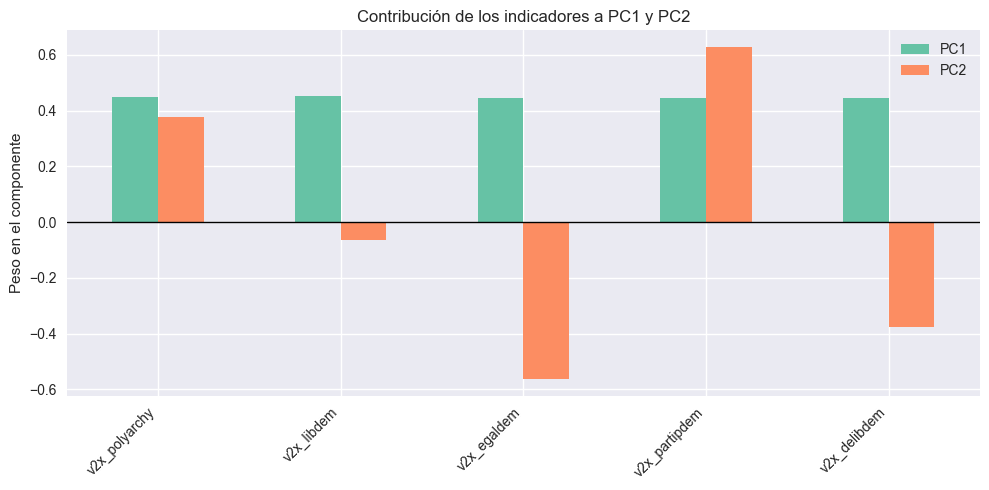

In [13]:
# --- Importancia de cada indicador en los componentes PCA ---

indicadores_pca = [
    "v2x_polyarchy",
    "v2x_libdem",
    "v2x_egaldem",
    "v2x_partipdem",
    "v2x_delibdem"
]


loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2"],
    index=indicadores_pca
)

print("Contribución de los indicadores a los componentes PCA:")
display(loadings.round(3))


# Visualización en gráfico de barras
plt.figure(figsize=(8, 4))
loadings.plot(kind='bar', figsize=(10, 5))
plt.title("Contribución de los indicadores a PC1 y PC2")
plt.axhline(0, color='black', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Peso en el componente")
plt.tight_layout()
plt.show()

### 3.2.2 Interpretación de loadings

- **PC1** carga fuertemente (y de forma positiva) en los 5 indicadores →  
  es un **índice global de calidad democrática**
- **PC2** diferencia modelos de democracia según:
  - participación → peso positivo fuerte
  - igualdad política y deliberación → pesos negativos

📌 **PC1** separa democracias ↔ autoritarismos  
📌 **PC2** distingue **modelos democráticos internos**

### 3.2.3 Conclusiones PCA (2024)

- PC1 explica **casi el 97%** de la varianza → la democracia es una **dimensión dominante** a nivel global
- PC2 introduce **variaciones más sutiles** dentro del universo democrático
- La estructura PC1–PC2 es **conceptualmente coherente con la teoría política comparada**

### 3.3 Visualización inicial del espacio PCA

Se grafica la posición de cada país en el nuevo espacio de dos dimensiones definido por PCA, lo que permite observar cómo se distribuyen las configuraciones democráticas en 2024 antes de aplicar algoritmos de agrupamiento.

Esta visualización facilita identificar patrones políticos globales y posibles grupos de países con características democráticas similares.

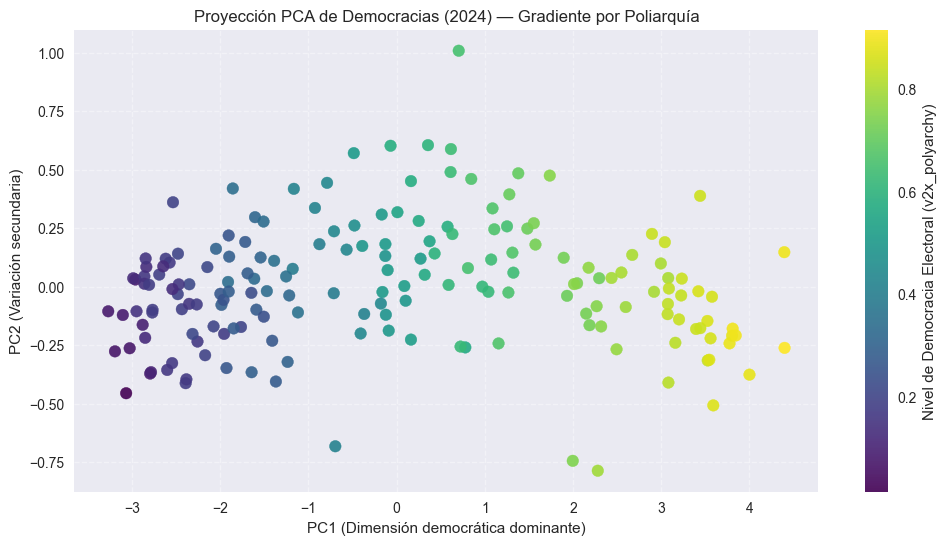

In [14]:
# --- Visualización PCA con gradiente de democracia electoral ---

plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'],
    c=df_sel['v2x_polyarchy'],   # escala de color según puntuación democrática
    cmap='viridis',
    s=70,
    alpha=0.9
)

plt.title("Proyección PCA de Democracias (2024) — Gradiente por Poliarquía")
plt.xlabel("PC1 (Dimensión democrática dominante)")
plt.ylabel("PC2 (Variación secundaria)")

# Agregar barra de color interpretativa
cbar = plt.colorbar(scatter)
cbar.set_label("Nivel de Democracia Electoral (v2x_polyarchy)")

plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

### 3.3.1 Interpretación inicial del espacio PCA (sin clustering)

El plano PCA muestra una **estructura política global reconocible**:

- **PC1** explica casi toda la variación y **ordena el mundo político** en un eje
  que separa **autocracias** ↔ **democracias plenas**
- **PC2** introduce cambios más sutiles, vinculados a matices en participación y
  calidad institucional dentro del mundo democrático

Se utiliza el índice **`v2x_polyarchy`** como escala de color, lo que permite observar
que los países con mayor democracia electoral **se concentran en los valores altos de PC1**
(marcados en colores más cálidos), mientras que los regímenes con derechos políticos
restringidos se ubican en el extremo opuesto del eje.

📌 En síntesis:  
El PCA **ya revela una tipología democrática implícita**, incluso sin aplicar clustering.

## 4. Agrupamiento de países (Clustering)

Una vez reducido el espacio a dos dimensiones relevantes mediante PCA,
se aplican técnicas de **aprendizaje no supervisado** para identificar
tipologías de regímenes políticos en 2024.

Se utilizará **K-Means**, un algoritmo que busca particionar los datos
en grupos internamente similares y externamente distintos.

Para determinar el número óptimo de clusters (**k**), se evaluarán dos
criterios complementarios:

- **El método del codo (Elbow Method)**
- **El Silhouette Score**

Aunque el Silhouette Score suele utilizarse con K-Medoids, también es ampliamente aplicado con K-Means como métrica para evaluar el balance
entre cohesión interna y separación entre clusters.

### 4.1 Selección del número de clusters — Método del Codo

Se evalúa el comportamiento de la inercia (suma de distancias intra-cluster)
para distintos valores de **k**, con el objetivo de encontrar un punto a partir
del cual la mejora es marginal (el “codo”).

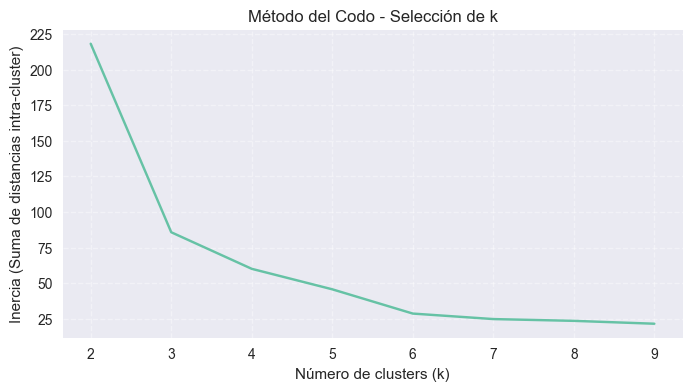

In [15]:
# --- Método del Codo (Elbow Method) ---
# Evaluamos la inercia para distintos valores de k (2 a 9)

inertia_values = []
K_values = range(2, 10)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df[["PC1", "PC2"]])
    inertia_values.append(kmeans.inertia_)

# Gráfico del codo para seleccionar k óptimo
plt.figure(figsize=(8, 4))
plt.plot(K_values, inertia_values, marker="x")
plt.title("Método del Codo - Selección de k")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (Suma de distancias intra-cluster)")
plt.grid(True, linestyle='--', alpha=0.4)

# Se guarda la figura
plt.savefig("figures/elbow_method.png", dpi=300, bbox_inches="tight")

plt.show()

**Conclusión del método del codo**

El punto de inflexión se observa claramente en **k = 3**, donde la reducción
de inercia comienza a volverse marginal. Por lo tanto, se selecciona:

📌 **Número óptimo de clusters según Elbow Method: k = 3**

### 4.2 Validación del número de clusters — Silhouette Score

El **Silhouette Score** evalúa la cohesión y separación entre clusters:

- Valores cercanos a **+1** → excelente separación entre grupos  
- Valores cercanos a **0** → clusters muy solapados  
- Valores **negativos** → mala asignación de países a los clusters  

Esta métrica permite **confirmar empíricamente** cuántos grupos reflejan mejor la estructura democrática global en 2024.

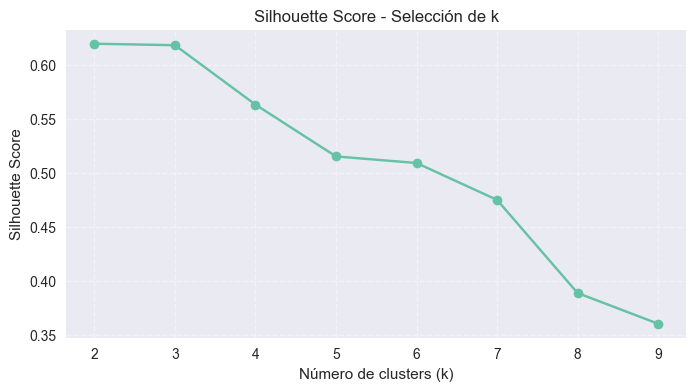

In [16]:
# --- Validación del número de clusters con Silhouette Score ---
# Evaluamos el Silhouette Score para distintos valores de k (2 a 9)

silhouette_scores = []
K_values = range(2, 10)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pca_df[["PC1", "PC2"]])
    score = silhouette_score(pca_df[["PC1", "PC2"]], labels)
    silhouette_scores.append(score)

# Visualización
plt.figure(figsize=(8, 4))
plt.plot(K_values, silhouette_scores, marker="o")
plt.title("Silhouette Score - Selección de k")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True, linestyle='--', alpha=0.4)

# Se guarda la figura
plt.savefig("figures/silhouette_score.png", dpi=300, bbox_inches="tight")

plt.show()

**Conclusión del Silhouette Score**

El Silhouette Score alcanza uno de sus valores más altos en **k = 3**, indicando una buena separación entre clusters y cohesión interna dentro de cada grupo.

📌 **Número óptimo de clusters según Silhouette Score: k = 3**

### 4.3 Aplicación de K-Means con *k = 3*

Con el valor de **k=3** validado por Elbow y Silhouette, entrenamos **K-Means** sobre el espacio reducido por **PCA (PC1–PC2)**. Luego visualizamos los grupos y sus **centroides**, para observar la separación geométrica y preparar la caracterización de cada cluster.

In [17]:
# --- Entrenamiento de K-Means con k=3 ---
k_opt = 3
kmeans_final = KMeans(n_clusters=k_opt, random_state=42)
pca_df["cluster"] = kmeans_final.fit_predict(pca_df[["PC1", "PC2"]])

# Centroides para visualización
centroids = kmeans_final.cluster_centers_

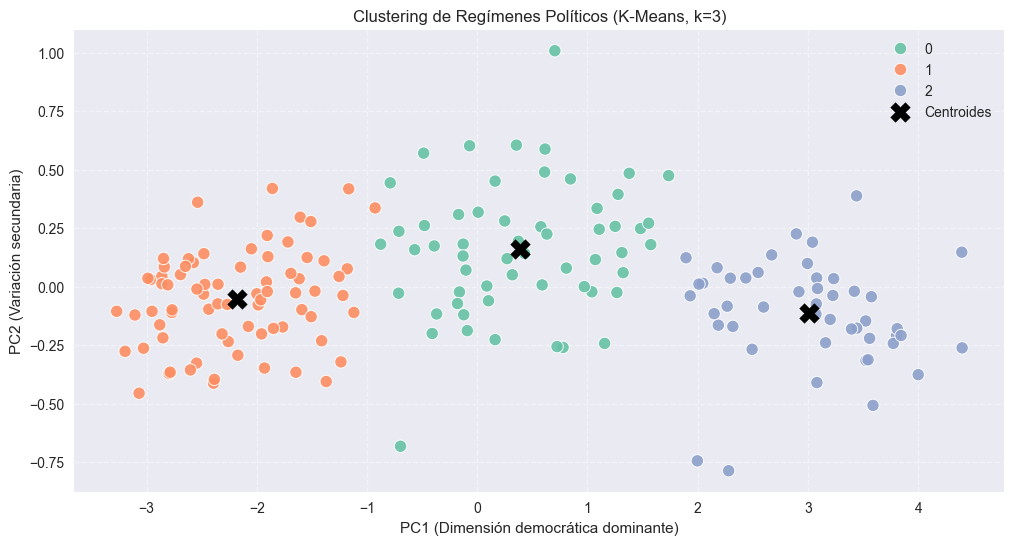

In [18]:
# --- Gráfico de clusters ---
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="cluster",
    palette="Set2",
    s=80,
    alpha=0.9
)

# Centroides
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    c="black", s=200, marker="X", label="Centroides"
)

plt.title("Clustering de Regímenes Políticos (K-Means, k=3)")
plt.xlabel("PC1 (Dimensión democrática dominante)")
plt.ylabel("PC2 (Variación secundaria)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# Se guarda la figura
plt.savefig("figures/kmeans_clusters.png", dpi=300, bbox_inches="tight")

plt.show()

### Interpretación inicial de clusters

- Los **clusters se distinguen principalmente sobre PC1**, 
  reflejando diferencias claras en calidad democrática general.
- PC2 aporta detalles adicionales entre modelos democráticos 
  (participación vs. igualdad / deliberación).

📌 Los resultados sugieren al menos **tres tipologías globales**:

1️⃣ **Democracias consolidadas**  
2️⃣ **Democracias intermedias / híbridas**  
3️⃣ **Regímenes autoritarios**

El análisis detallado de cada grupo se realizará a continuación.

## 5. Análisis de los clusters identificados

Una vez definidos los grupos mediante K-Means, el siguiente paso consiste en
**caracterizar** cada cluster para comprender:

- qué **tipologías de regímenes políticos** representa cada grupo
- qué **países** componen los clusters
- qué **dimensiones democráticas** diferencian más a cada uno

Este análisis combina:
1) **Exploración cuantitativa**: distribución y promedios por indicador  
2) **Interpretación politológica**: lectura sustantiva de los resultados

Primero observaremos la **distribución de países por cluster** y una primera
mirada comparativa dentro de cada grupo.

### 5.1 Distribución de países por cluster

Se analiza cuántos países componen cada grupo y se listan algunos ejemplos ordenados por PC1 (dimensión democrática dominante).

Esto permite comenzar a interpretar los clusters desde una perspectiva comparada antes de analizar cuantitativamente sus perfiles institucionales.

In [19]:
# --- Cantidad de países por cluster ---
cluster_counts = pca_df["cluster"].value_counts().sort_index()
display(cluster_counts)

# --- Países ordenados por PC1 dentro de cada cluster ---
top_n = 8  # cantidad de países de ejemplo por grupo

resume_clusters = (
    pca_df[["country_name", "cluster", "PC1", "PC2"]]
    .sort_values(["cluster", "PC1"], ascending=[True, False])
    .groupby("cluster")
    .head(top_n)
)

display(resume_clusters)

cluster
0    57
1    75
2    47
Name: count, dtype: int64

,country_name,cluster,PC1,PC2
172,Slovakia,0,1.736030,0.474372
85,Panama,0,1.573830,0.179581
67,Timor-Leste,0,1.554918,0.270940
30,Argentina,0,1.481591,0.247858
12,Colombia,0,1.378771,0.484182
119,Moldova,0,1.323121,0.059497
167,Sao Tome and Principe,0,1.312360,0.145164
107,Dominican Republic,0,1.277301,0.394171
131,Somaliland,1,-0.926495,0.336144
127,Togo,1,-1.119300,-0.110407


C:\Users\elias\AppData\Local\Temp\ipykernel_9124\1627459844.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="Set2")


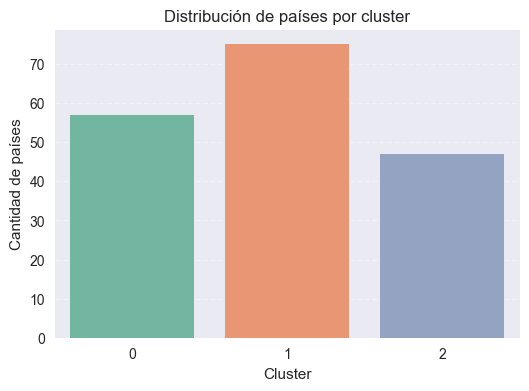

In [20]:
plt.figure(figsize=(6, 4))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="Set2")
plt.title("Distribución de países por cluster")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de países")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

**Conclusión inicial**

Los clusters muestran tamaños comparables, lo que sugiere que el modelo no produce grupos residualizados sino **tipos de regímenes relativamente extendidos** en el mundo:

- Cluster 0: predominan **regímenes autoritarios o híbridos**
- Cluster 1: **democracias intermedias**, con variada calidad institucional
- Cluster 2: **democracias consolidadas** con altos niveles en todas las dimensiones

El análisis cuantitativo de indicadores permitirá **validar y precisar** estas categorías.

### 5.2 Perfil democrático de cada cluster

Para entender qué distingue a cada grupo, se comparan los **promedios** de los cinco indicadores democráticos utilizados en el clustering.

Esto permite construir un **perfil institucional** de cada tipo de régimen, observando fortalezas y debilidades relativas en:

- Democracia electoral
- Democracia liberal
- Igualdad política
- Participación ciudadana
- Instituciones deliberativas

In [21]:
# Incorporamos los labels del clustering a df_sel para su análisis descriptivo
df_sel["cluster"] = pca_df["cluster"].values

# --- Promedio de indicadores democráticos por cluster ---
cluster_means = (
    df_sel[[
        "cluster",
        "v2x_polyarchy",
        "v2x_libdem",
        "v2x_egaldem",
        "v2x_partipdem",
        "v2x_delibdem"
    ]]
    .groupby("cluster")
    .mean()
    .round(3)
)

display(cluster_means)

,v2x_polyarchy,v2x_libdem,v2x_egaldem,v2x_partipdem,v2x_delibdem
cluster,,,,,
0,0.568,0.420,0.380,0.353,0.397
1,0.217,0.115,0.149,0.120,0.133
2,0.817,0.733,0.694,0.564,0.710


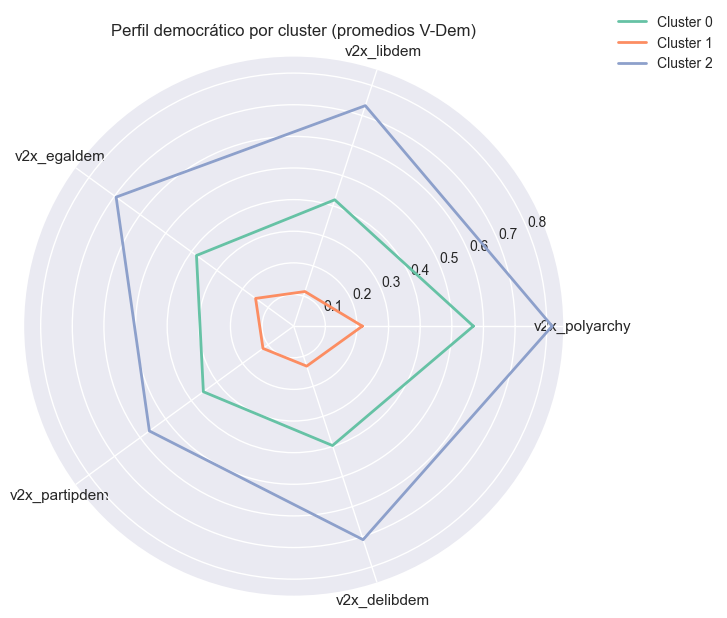

In [22]:
# --- Radar Chart de perfiles por cluster ---

from math import pi

# Variables
categories = cluster_means.columns.tolist()
N = len(categories)

# Ángulos del radar
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # cierre del polígono

plt.figure(figsize=(7, 7))

for cluster in cluster_means.index:
    values = cluster_means.loc[cluster].tolist()
    values += values[:1]
    plt.polar(
        angles,
        values,
        label=f"Cluster {cluster}",
        linewidth=2
    )

# Estética
plt.xticks(angles[:-1], categories, fontsize=11)
plt.title("Perfil democrático por cluster (promedios V-Dem)")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()

### Interpretación del perfil democrático por cluster (promedios V-Dem)

El gráfico radar revela **tres patrones democráticos diferenciados**:

1️⃣ **Cluster 2 – Democracias consolidadas**
- Altos valores en **casi todas** las dimensiones (≈ 0.75–0.85)
- **Participación** algo más moderada (≈ 0.65)
- Instituciones liberales y deliberativas muy fuertes

2️⃣ **Cluster 0 – Democracias intermedias / regímenes híbridos**
- Valores **moderados** en participación, igualdad y deliberación (≈ 0.35–0.50)
- Elecciones competitivas, pero **limitaciones institucionales**
- Incluye **democracias delegativas o en transición**

3️⃣ **Cluster 1 – Regímenes autoritarios**
- Valores **muy bajos** en todos los indicadores (≈ 0.10–0.25)
- Alta restricción en derechos y rendición de cuentas
- **Ausencia de pluralismo político real**

📌 **PC1** diferencia autoritarismos ↔ democracias  
📌 **PC2** introduce matices entre modelos democráticos  
(participación ↔ instituciones liberales / deliberativas)

➡️ El clustering confirma una tipología consistente con la teoría política:
**Autoritarismos → Democracias híbridas → Democracias consolidadas**

### 5.3 Exploración de países dentro de cada cluster

Para complementar el análisis institucional, se examinan los **países** que componen cada uno de los tres grupos identificados mediante clustering.

Este paso permite:

- validar empíricamente las **etiquetas analíticas** asignadas a cada cluster  
- identificar **casos representativos** y posibles **outliers**  
- conectar los resultados cuantitativos con el **contexto político real**  

Los listados se ordenan según la dimensión democrática principal (PC1).

In [23]:
# Ordenar países por nivel democrático (PC1)
sorted_df = pca_df.sort_values(["cluster", "PC1"], ascending=[True, False])

# Cantidad de países a visualizar por cada extremo
top_n = 5

cluster_examples = []

for cluster in sorted_df["cluster"].unique():
    sub = sorted_df[sorted_df["cluster"] == cluster]

    mejores = sub.head(top_n)
    peores = sub.tail(top_n)

    cluster_examples.append(pd.DataFrame({
        "cluster": cluster,
        "tipo": ["Mejor"] * top_n + ["Peor"] * top_n,
        "country_name": pd.concat([mejores["country_name"], peores["country_name"]]),
        "PC1": pd.concat([mejores["PC1"], peores["PC1"]])
    }))

cluster_examples_df = pd.concat(cluster_examples).reset_index(drop=True)

display(cluster_examples_df)

,cluster,tipo,country_name,PC1
0,0,Mejor,Slovakia,1.736030
1,0,Mejor,Panama,1.573830
2,0,Mejor,Timor-Leste,1.554918
3,0,Mejor,Argentina,1.481591
4,0,Mejor,Colombia,1.378771
5,0,Peor,Singapore,-0.695849
6,0,Peor,Hungary,-0.710503
7,0,Peor,Ukraine,-0.713348
8,0,Peor,Philippines,-0.789072
9,0,Peor,India,-0.876052


Los resultados confirman que los clusters reflejan patrones políticos reales:

- El **cluster 2** reúne las **democracias consolidadas**
- El **cluster 1** agrupa **regímenes autoritarios o híbridos**
- El **cluster 0** contiene **democracias intermedias / en transición**

Argentina se ubica en el **cluster 0**, consistente con la categoría de
**democracia intermedia** con fortalezas electorales pero debilidades
institucionales.

### 5.4 Exportación del dataset final procesado

In [36]:
# --- Exportación del dataset final procesado ---

# Unión de datos PCA y atributos por país
df_final = df_sel.merge(
    pca_df[["country_id", "PC1", "PC2"]],
    on="country_id",
    how="left"
)

# Selección y orden de columnas
cols = [
    "country_id", "country_name", "iso3",
    "cluster", "cluster_label",
    "PC1", "PC2",
    "v2x_polyarchy", "v2x_libdem", "v2x_egaldem",
    "v2x_partipdem", "v2x_delibdem"
]

df_final = df_final[cols]

# Exportar a CSV
output_path = "data/processed/vdem_clusters_2024.csv"
df_final.to_csv(output_path, index=False)

print(f"Dataset procesado exportado correctamente a: {output_path}")
df_final.head()

Dataset procesado exportado correctamente a: data/processed/vdem_clusters_2024.csv


,country_id,country_name,iso3,cluster,cluster_label,PC1,PC2,v2x_polyarchy,v2x_libdem,v2x_egaldem,v2x_partipdem,v2x_delibdem
0,3,Mexico,MEX,0,Democracias intermedias / híbridas,-0.486049,0.570347,0.505,0.251,0.268,0.345,0.260
1,4,Suriname,SUR,2,Democracias consolidadas,2.176055,0.080543,0.768,0.637,0.575,0.497,0.599
2,5,Sweden,SWE,2,Democracias consolidadas,3.803226,-0.209956,0.881,0.845,0.795,0.630,0.793
3,6,Switzerland,CHE,2,Democracias consolidadas,4.395336,0.147090,0.894,0.847,0.830,0.794,0.862
4,7,Ghana,GHA,0,Democracias intermedias / híbridas,1.155349,-0.242884,0.669,0.567,0.455,0.320,0.546


## 6. Visualización geográfica de los clusters

Para contextualizar geopolíticamente los resultados, se proyectan los **tres tipos de regímenes políticos** identificados mediante K-Means sobre un **mapa mundial**.

Este análisis permite:

- observar la **distribución regional** de cada tipología democrática  
- identificar bloques espaciales (Europa, África Subsahariana, Medio Oriente, etc.)  
- detectar **patrones geopolíticos** y posibles excepciones  

Se utilizarán dos enfoques complementarios:

1️⃣ **Mapa estático** con `Geopandas` → vista general profesional  
2️⃣ **Mapa interactivo** con `Plotly` → exploración país por país  

Cada país será coloreado según su cluster asignado:
- 🟢 Cluster 2 → **Democracias consolidadas**  
- 🟡 Cluster 0 → **Democracias intermedias / híbridas**  
- 🔴 Cluster 1 → **Regímenes autoritarios**

### 6.1 Asignación inicial de códigos ISO3 con PyCountry

Para poder representar los clusters en mapas geográficos se requiere un identificador estandarizado por país. Se utiliza el código **ISO Alpha-3 (ISO3)**, ampliamente soportado por librerías de geovisualización.

En esta etapa se intenta asignar el código ISO3 automáticamente mediante la biblioteca `pycountry`.

In [24]:
# --- Asignación inicial de códigos ISO Alpha-3 con PyCountry ---

def get_iso3(country_name):
    """
    Retorna el código ISO3 asociado al nombre del país usando pycountry.
    Si no se encuentra coincidencia exacta, devuelve NaN.
    """
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except:
        return np.nan

# Aplicamos la función al nombre del país
df_sel["iso3"] = df_sel["country_name"].apply(get_iso3)

# Vista inicial de resultados asignados
display(df_sel[["country_name", "iso3"]].head(10))

,country_name,iso3
235,Mexico,MEX
360,Suriname,SUR
596,Sweden,SWE
823,Switzerland,CHE
946,Ghana,GHA
1071,South Africa,ZAF
1307,Japan,JPN
1543,Burma/Myanmar,NaN
1779,Russia,NaN
1892,Albania,ALB


In [25]:
# Se identifican países sin código ISO3 asignado
missing_iso = df_sel[df_sel["iso3"].isnull()][["country_name"]]

print(f"Países sin código ISO3 asignado: {len(missing_iso)}")
display(missing_iso)

Países sin código ISO3 asignado: 11


,country_name
1543,Burma/Myanmar
1779,Russia
6730,Kosovo
9727,Ivory Coast
10627,Cape Verde
16777,Democratic Republic of the Congo
17604,The Gambia
18663,Palestine/West Bank
19530,Palestine/Gaza
19624,Somaliland


In [26]:
# --- Corrección manual de nombres no estándar para asignar ISO3 ---

iso3_fixes = {
    "Burma/Myanmar": "MMR",
    "Russia": "RUS",
    "Kosovo": "XKX",  # Código reconocido informalmente y soportado por geodata
    "Ivory Coast": "CIV",
    "Cape Verde": "CPV",
    "Democratic Republic of the Congo": "COD",
    "The Gambia": "GMB",
    "Palestine/West Bank": "PSE",
    "Palestine/Gaza": "PSE",  # Mismo ISO3 que Palestina reconocida
    "Somaliland": np.nan,  # No reconocido como Estado soberano
    "Zanzibar": np.nan     # Parte de Tanzania → sin ISO3 propio
}

# Se aplican correcciones
df_sel["iso3"] = df_sel.apply(
    lambda row: iso3_fixes.get(row["country_name"], row["iso3"]),
    axis=1
)

# Se verifican resultados nuevamente
missing_iso_after = df_sel[df_sel["iso3"].isnull()][["country_name"]]

print(f"Países que aún no tienen ISO3: {len(missing_iso_after)}")
display(missing_iso_after)

Países que aún no tienen ISO3: 2


,country_name
19624,Somaliland
26513,Zanzibar


**Conclusión de la asignación geográfica**

Luego de corregir manualmente los nombres no estándar, solo **dos territorios** siguen sin un código ISO3 válido:

- **Somaliland** → no reconocido como Estado soberano por la ONU - **Zanzibar** → parte territorial de **Tanzania**

Por lo tanto, estos casos **no pueden representarse en el mapa mundial** bajo convenciones internacionales y serán excluidos únicamente de la visualización geográfica, manteniéndose en el análisis numérico general.

### 6.3 Mapa mundial interactivo de clusters (Plotly)

A continuación, se representa la distribución global de los **tres tipos de regímenes políticos** identificados mediante K-Means, sobre un mapa mundial interactivo utilizando `Plotly`.

El mapa permite:

- visualizar **bloques democráticos regionales**;
- explorar la situación de cada país mediante **hover interactivo**;
- identificar **excepciones geopolíticas** y fronteras políticas marcadas.

Cada país está coloreado según su cluster:

| Cluster | Color | Interpretación |
|--------:|:-----:|----------------|
| 2 | 🟢 Verde | Democracias consolidadas |
| 0 | 🟡 Amarillo | Democracias intermedias / híbridas |
| 1 | 🔴 Rojo | Regímenes autoritarios |

📌 Interacción disponible: *posar el cursor sobre un país para ver cluster y valores de PC1–PC2*

In [ ]:
# Se mapea el número de cluster a una etiqueta descriptiva
cluster_labels = {
    "2": "Democracias consolidadas",
    "0": "Democracias intermedias / híbridas",
    "1": "Regímenes autoritarios"
}

# Se crea nueva columna con la etiqueta del cluster
df_sel["cluster_label"] = df_sel["cluster"].map(cluster_labels)

In [ ]:
# Mapa mundial interactivo coloreado según el tipo de régimen político
fig = px.choropleth(
    df_sel,
    locations="iso3",
    color="cluster_label",
    hover_name="country_name",
    hover_data={
        "cluster_label": True,
        "PC1": np.round(pca_df["PC1"], 3),
        "PC2": np.round(pca_df["PC2"], 3),
        "iso3": False
    },
    title="Tipologías Democráticas Globales - Clustering K-Means (2024)",
    color_discrete_map={
        "Democracias consolidadas": "green",
        "Democracias intermedias / híbridas": "gold",
        "Regímenes autoritarios": "red"
    }
)

fig.update_geos(showcountries=True)
fig.update_layout(
    legend_title_text="Tipo de régimen político",
    title_x=0.5
)

fig.write_html("figures/democracy_clusters_map.html")

fig.show()

### 📌 Interpretación geopolítica del mapa interactivo

El mapa mundial revela **patrones regionales muy marcados** en la distribución
de los tres tipos de regímenes políticos identificados mediante clustering:

🟢 **Cluster 2 — Democracias consolidadas**  
- Se concentran en **Europa Occidental**, **Oceanía**, **Norteamérica** y algunos países de **Asia Oriental**.  
- Instituciones fuertes, alta rendición de cuentas y libertad de participación ciudadana.

🟡 **Cluster 0 — Democracias intermedias / híbridas**  
- Predominan en **América Latina**, **Europa del Este**, sectores de **Asia Sudoriental** y regiones del **Norte de África**.  
- Sistemas electorales competitivos, pero **instituciones frágiles** y desigualdad persistente.

🔴 **Cluster 1 — Regímenes autoritarios**  
- Mayor presencia en **Medio Oriente**, **Asia Central** y **África Subsahariana**.  
- Concentración del poder, restricciones severas a libertades políticas y participación ciudadana.

---

📍 **Argentina** se ubica en el *cluster 0*, en línea con su clasificación como  
**democracia electoral con debilidades institucionales**.

---

📎 **En síntesis:**

> La geografía política global continúa mostrando una división clara entre  
> democracias consolidadas, regímenes híbridos y autoritarismos, con algunos  
> casos excepcionales que desafían patrones regionales tradicionales.

## 7. Conclusiones y próximos pasos

Este proyecto identificó **tres tipologías globales de regímenes políticos en 2024** utilizando
clustering no supervisado a partir de indicadores consolidados del dataset **V-Dem v15**.

### ✅ Conclusiones principales

🔹 **La democracia es una dimensión dominante a nivel global**  
El PCA mostró que PC1 explica ~97% de la variabilidad → diferencias claras entre:
- **Democracias consolidadas**
- **Regímenes autoritarios**
- **Sistemas híbridos o en transición**

🔹 **Se distinguieron 3 clusters globales:**
| Cluster | Significado | Regiones predominantes |
|--------:|-------------|----------------------|
| 🟢 2 | Democracias consolidadas | Europa Occidental, Norteamérica, Oceanía, Asia Oriental |
| 🟡 0 | Democracias intermedias / híbridas | América Latina, Europa del Este, Norte de África |
| 🔴 1 | Regímenes autoritarios | Medio Oriente, Asia Central, África Subsahariana |

🔹 **Coherencia con la teoría política**  
Los resultados cuantitativos reflejan dinámicas geopolíticas ampliamente documentadas.

---

### 📍 Caso Argentina
- Se ubica en el **Cluster 0** → Democracia con buena calidad electoral,
  pero con **debilidades institucionales** persistentes.

---

### ⚠️ Limitaciones del análisis
- Se utilizó únicamente la **foto actual** (2024) → no se refleja la evolución democrática.
- La clasificación **no es normativa**, sino estadística: agrupa similitudes en indicadores,
  no juicios sustantivos sobre “mejor” o “peor” sistema.

---

### 🚀 Próximos pasos sugeridos

📌 Extensiones metodológicas:
- Incorporar **series temporales** (1990–2024) → evolución de trayectorias democráticas
- Probar métodos más robustos de clustering (**DBSCAN**, **GMM**)
- Añadir más indicadores (p. ej., derechos de minorías, control de corrupción)

📌 Visualizaciones adicionales:
- Mapa **interactivo** con hover de métricas
- **Dashboard** en Power BI / Tableau / Plotly Dash

📌 Validación politológica:
- Contrastar resultados con clasificaciones externas:
  - Freedom House
  - Economist Democracy Index
  - Polity5

---

📎 En síntesis:

> **La tipología identificada es empíricamente sólida, teóricamente compatible y geopolíticamente interpretable**, lo que la convierte en un excelente insumo para investigación y toma de decisiones pública internacional.